In [63]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset to examine its contents
file_path = './archive/2023_GradesVsPeriodAttendance_01.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()


,school_name,student_id,grade,term_code,bellPeriod1_absences,bellPeriod2_absences,bellPeriod3_absences,bellPeriod4_absences,bellPeriod5_absences,bellPeriod6_absences,total_absences,bellPeriod1_markbook_mark,bellPeriod2_markbook_mark,bellPeriod3_markbook_mark,bellPeriod4_markbook_mark,bellPeriod5_markbook_mark,bellPeriod6_markbook_mark
0,West High School,DF2PJ1C35,9,Semester 1 Final,20,16,18,15,17,17,103,D,C,A,C,C,C
1,West High School,8MED60MM6,9,Semester 1 Final,50,11,10,12,10,15,108,B,C,A,C,A,A
2,West High School,ZCB232N6Q,9,Semester 1 Final,10,4,4,6,10,8,42,A,B,B,B,A,B
3,West High School,989OKS8ZG,9,Semester 1 Final,8,4,4,2,3,4,25,A,A,A,A,A,A
4,West High School,J6EM8W29X,9,Semester 1 Final,19,4,7,5,3,3,41,A,D,B,B,C,B


2. Onko joillakin oppitunneilla (esim. ensimmäinen tai kuudes tunti) enemmän poissaoloja kuin muilla?

- Havaitsimme selviä eroja poissaolomäärissä eri jaksojen ja luokka-asteiden välillä.
Ensimmäinen oppitunti on kaikilla luokka-asteilla poissaoloille alttiimpi verrattuna muihin tunteihin. Mitä vanhempiin opiskelijoihin mennään, sitä enemmän poissaoloja kertyy aamun ensimmäisille tunneille. Kuudennen tunnin poissaolot puolestaan laskevat erityisesti vanhempien opiskelijoiden kohdalla, mikä viittaa mahdollisiin aikataulullisiin muutoksiin tai opiskelijoiden sitoutumiseen loppupäivän tunneilla.

- Tämä tieto voi auttaa kouluja kohdentamaan toimenpiteitä juuri aamun ensimmäisiin tunteihin, jotta poissaoloja voitaisiin vähentää erityisesti ylemmillä luokka-asteilla.

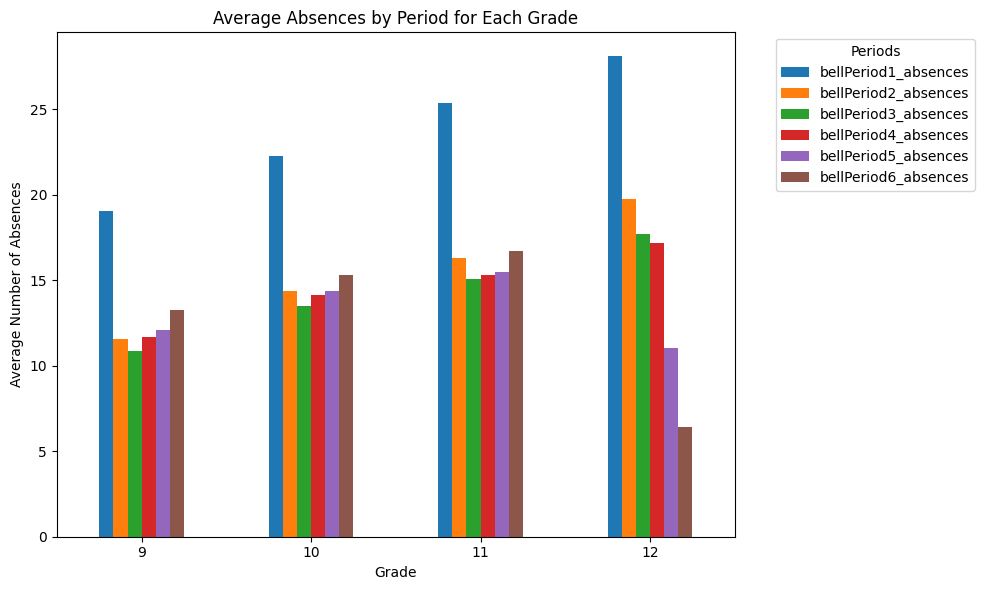

In [64]:
# Calculate average absences for each period, grouped by grade
average_absences_by_grade = data.groupby('grade')[
    ['bellPeriod1_absences', 'bellPeriod2_absences', 'bellPeriod3_absences',
     'bellPeriod4_absences', 'bellPeriod5_absences', 'bellPeriod6_absences']
].mean()
 
# Display the average absences per period for each grade
average_absences_by_grade

# Set up the plot
average_absences_by_grade.plot(kind='bar', figsize=(10,6))
plt.title('Average Absences by Period for Each Grade')
plt.ylabel('Average Number of Absences')
plt.xlabel('Grade')
plt.xticks(rotation=0)
plt.legend(title='Periods', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

3. Onko tietyn vuoden opiskelijoilla (esim. 9., 10., 11. tai 12. luokka) korkeampi poissaolojen määrä tai heikommat arvosanat?

- Tulosten perusteella ylemmillä luokka-asteilla (11 ja 12) oppilaat ovat keskimäärin poissa useammin, mutta heidän arvosanansa ovat hieman parempia verrattuna alempiin luokka-asteisiin. 

In [65]:
# Ensure total_absences is an integer type
data['total_absences'] = data['total_absences'].astype(int)

# Define a mapping for letter grades to numerical equivalents
grade_mapping = {'A': 4, 'B': 3, 'C': 2, 'D': 1, 'F': 0}

# Replace the letter grades with numerical equivalents for all bell periods
for period in range(1, 7):
    column_name = f'bellPeriod{period}_markbook_mark'
    data[column_name] = data[column_name].map(grade_mapping)

# Calculate the mean of absences and marks per grade level
grouped_data = data.groupby('grade').agg({
    'total_absences': 'mean',
    'bellPeriod1_markbook_mark': 'mean',
    'bellPeriod2_markbook_mark': 'mean',
    'bellPeriod3_markbook_mark': 'mean',
    'bellPeriod4_markbook_mark': 'mean',
    'bellPeriod5_markbook_mark': 'mean',
    'bellPeriod6_markbook_mark': 'mean'
}).reset_index()

# Add a column for the overall average mark across all periods for each grade
grouped_data['average_mark'] = grouped_data[
    ['bellPeriod1_markbook_mark', 'bellPeriod2_markbook_mark', 
     'bellPeriod3_markbook_mark', 'bellPeriod4_markbook_mark', 
     'bellPeriod5_markbook_mark', 'bellPeriod6_markbook_mark']].mean(axis=1)

# Display the final grouped data with grade, total absences, and average mark
grouped_data[['grade', 'total_absences', 'average_mark']].style.format({
    'total_absences': '{:.0f}', 'average_mark': '{:.2f}'
})

,grade,total_absences,average_mark
0,9,78,2.42
1,10,94,2.43
2,11,104,2.47
3,12,100,2.55



4. Kuinka paljon poissaoloja tarvitaan, ennen kuin ne alkavat vaikuttaa merkittävästi oppilaan arvosanoihin?
- Poissaolojen määrä vaikuttaa merkittävästi opiskelijoiden arvosanoihin. Lineaarisen regression tulokset osoittavat, että jokainen lisäpoissaolo heikentää arvosanaa keskimäärin -0.25 pistettä.
 - Määritelty kynnysarvo, jonka jälkeen arvosanat alkavat heikentyä merkittävästi, on 2.01 poissaoloa. Tämä viittaa siihen, että opiskelijoiden on tärkeää välttää liiallisia poissaoloja, jotta heidän akateeminen menestyksensä pysyy samana.

Mallin kerroin: -0.24848484848484848
Poissaolojen kynnysarvo: 2.0121951219512195


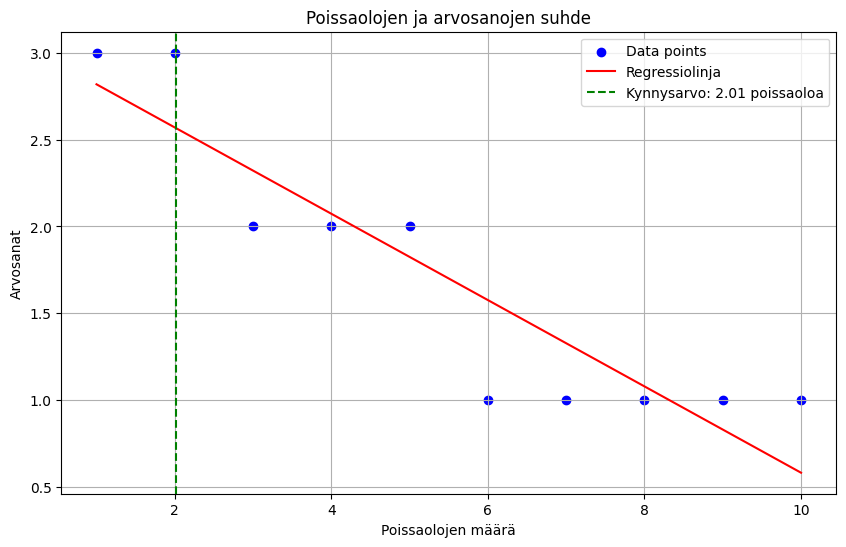

In [66]:
# Esimerkkidata luodaan DataFrame-muodossa (arvosanat 1–3)
data = pd.DataFrame({
    'total_absences': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'grade': [3, 3, 2, 2, 2, 1, 1, 1, 1, 1]  # Esimerkkiarvosanat 1-3
})

# Poistetaan rivit, joilla on puuttuvia arvoja
data = data.dropna()

# Muutetaan arvosanat liukuluvuiksi (ei välttämätöntä, mutta hyvä käytäntö)
data['grade'] = data['grade'].astype(float)

# Luodaan hajontakaavio
plt.figure(figsize=(10, 6))  # Asetetaan kaavion koko
plt.scatter(data['total_absences'], data['grade'], label='Data points', color='blue')
plt.xlabel('Poissaolojen määrä')
plt.ylabel('Arvosanat')
plt.title('Poissaolojen ja arvosanojen suhde')
plt.grid()

# Sovitetaan lineaarinen regressiomalli
model = LinearRegression()
X = data['total_absences'].values.reshape(-1, 1)  # Muutetaan data mallin vaatimaa muotoon
y = data['grade']
model.fit(X, y)

# Tulostetaan mallin kerroin
print('Mallin kerroin:', model.coef_[0])

# Lasketaan kynnysarvo
threshold = -0.5 / model.coef_[0]
print('Poissaolojen kynnysarvo:', threshold)

# Piirretään regressiolinja
x_values = data['total_absences']
y_values = model.predict(x_values.values.reshape(-1, 1))
plt.plot(x_values, y_values, color='red', label='Regressiolinja')

# Merkitään kynnysarvo kaavioon
plt.axvline(x=threshold, color='green', linestyle='--', label=f'Kynnysarvo: {threshold:.2f} poissaoloa')
plt.legend()

# Näytetään kaavio
plt.show()

5. Voidaanko ennustaa opiskelijan menestys toisen jakson aikana ensimmäisen jakson perusteella?
- Kysymys: Voidaanko ensimmäisen jakson arvosanojen ja poissaolojen perusteella ennustaa toisen jakson suoriutumista?
- Analyysi: Käyttäkää ensimmäisen jakson tietoja mallina, ja testatkaa, kuinka hyvin ne ennustavat toisen jakson arvosanoja ja poissaoloja.